In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [146]:
# Names file
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [148]:
# Building the vocab

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

In [149]:
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
      
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
  
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [150]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


In [155]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------

In [152]:
n_emb = 10
n_hidden = 200 

C = torch.randn(vocab_size, n_emb)

layers = [
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]
parameters = [C] + [p for layer in layers for p in layer.parameters()]


with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

22097


In [153]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # Forward pass
    emb = C[Xb] # Embedding the chars
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
#     for layer in layers:
#         x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        if p.grad == None:
            continue
        else:
            p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 4.8979
  10000/ 200000: 3.6606
  20000/ 200000: 3.6482
  30000/ 200000: 3.8574
  40000/ 200000: 3.8290
  50000/ 200000: 3.6195
  60000/ 200000: 3.4924
  70000/ 200000: 3.4409
  80000/ 200000: 3.7369
  90000/ 200000: 3.6222
 100000/ 200000: 3.6985
 110000/ 200000: 3.6552
 120000/ 200000: 3.6169
 130000/ 200000: 3.7202
 140000/ 200000: 3.6444
 150000/ 200000: 3.4110
 160000/ 200000: 3.4951
 170000/ 200000: 3.5409
 180000/ 200000: 3.8444
 190000/ 200000: 3.5681


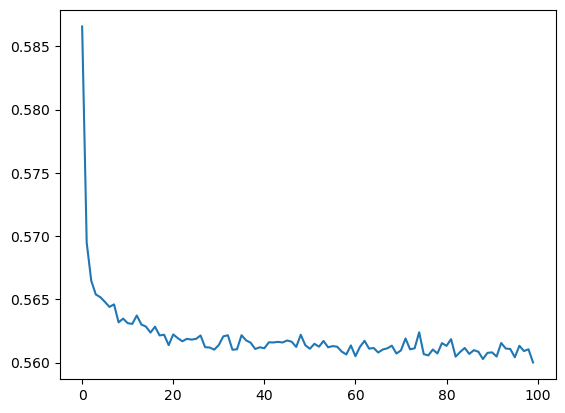

In [154]:
plt.plot(torch.tensor(lossi).view(-1,2000).mean(1))